In [5]:
using PhyloNetworks
using MultivariateStats
using StatsBase
using DataFrames
using SparseArrays
using ParallelKMeans
using MLBase
using Hungarian
using LinearAlgebra
using CSV
using Combinatorics
using CairoMakie
using Random

In [2]:
function num_bipartitions(n)
    return 2^(n-1) - 1
end;

function get_nodes(idx)
    nodes = []
    for i in 1:length(idx)
        if idx[i]
            append!(nodes, i)
        end
    end
    return nodes
end


function get_bipartition(tree, n)
    taxa = sort(tipLabels(tree))
    if length(taxa) != n
        print("check the parameter n")
        return
    end
    node = Vector(1:n)
    result = []
    idx = 0
    for i in tree.edge
        node_idx = hardwiredCluster(i,taxa)
        branch_node = get_nodes(node_idx)
        
        # if branch seperates more than half nodes, we use the small part to get bipartition idx
        if (length(branch_node) > n ÷ 2)
             branch_node = sort(collect(setdiff(node,branch_node)))
        end
        
        # generate all possible combination with the same number of nodes
        comb = collect(combinations(Vector(1:n), length(branch_node)))
        for c in 1:length(comb)
            if comb[c] == branch_node
                # if the combination is the later, we need to find its first half
                if length(branch_node) > 1 && c > length(comb) ÷ 2
                    c = length(comb) - c + 1 
                end
                idx = c - 1
                break
            end
        end
        for j in 1:(length(branch_node) - 1)
            idx = idx + binomial(n,j)
        end
        push!(result,Pair(idx, i.length))
        idx = 0
    end
    return result
end;

function print_bipartition(trees, n)
    
    # build the table
    N = num_bipartitions(n)
    data = zeros(length(trees), N)
    treeNum = 1;
    # get existing index
    
    for i in trees
        bipart = get_bipartition(i, n)
        for j in 1:length(bipart)
            data[treeNum,(bipart[j][1] + 1)] += bipart[j][2]
        end
        treeNum+=1
    end
    return data
end;


In [3]:
function ground_true(df_1, df_2)
    a = fill(1,size(df_1)[1])
    b = fill(2,size(df_2)[1])
    gt = cat(a,b, dims = 1)
    return gt
end

# convert tree from dataframe to matrix. Each column is a tree
function standardize_tree(tree)    
    data = collect(Matrix(tree)');
    
    # standardize tree
    dt = fit(ZScoreTransform, data, dims=2)
    data = StatsBase.transform(dt, data)
    
    # replace NaN value with 0
    replace!(data, NaN=>0)
    return data
end

function plot_clusters(tree, label)
    PCA_model = fit(PCA, tree, maxoutdim = 2);
    PCA_data = predict(PCA_model,tree)
    scatter(PCA_data[1,:], PCA_data[2,:], markersize = 5, color = label)
end

function accuracy(n, gt, pred)
    matrix = confusmat(n, gt, pred)
    # Hungarian algorithm minimizes the cost, so we need to transform the matrix
    A = -matrix .+ maximum(matrix)    
    matrix = matrix[:,hungarian(A)[1]]
    x = tr(matrix)/sum(matrix)
    return matrix, x
end

function kmeans_label(tree, n; seed =:"k-means++")  
    result = kmeans(tree, n; k_init ="k-means++");
    return result.assignments
end

function rep_kmeans_matrix(trees, path)
    n = length(trees)
    result = zeros(n, n)
    for i in 2:n
        for j in  1:(i - 1)
            gt = ground_true(trees[i],trees[j])
            tree = vcat(trees[i],trees[j])
            tree = standardize_tree(tree)
            for k in 1:10
                pred_kmeans = kmeans_label(tree, 2) 
                m,x = accuracy(2, gt, pred_kmeans)
                if x > result[i,j]
                    result[i,j] = x
                    result[j,i] = x
                end
            end
        end
    end      
    header = Vector(1:n)
    header = string.(header)
    CSV.write(path, DataFrame(result, :auto),header = header);
end

rep_kmeans_matrix (generic function with 1 method)

In [6]:
trees = readMultiTopology("dog-data/dogs_estimated_gene_trees_merged6_cleaned.txt");

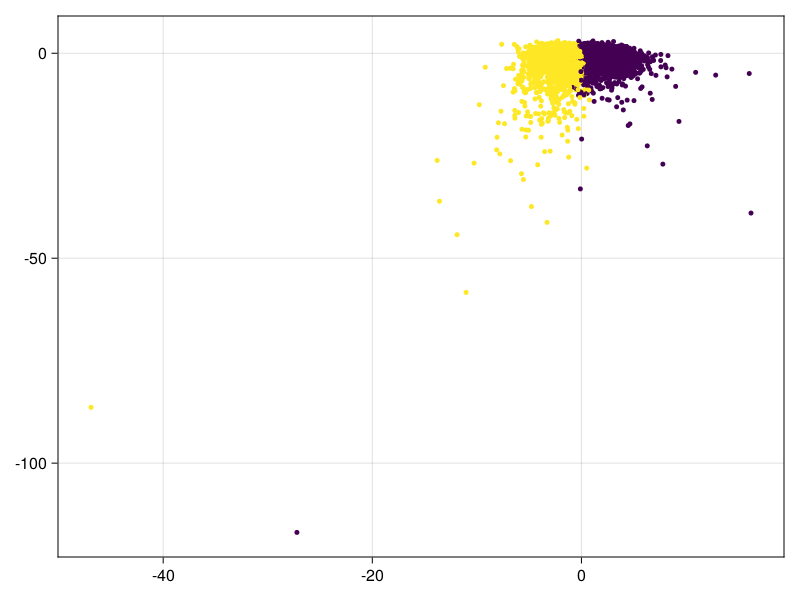

In [5]:
Random.seed!(376)
sample_tree = sample(trees, 100000, replace=false)
tree = print_bipartition(sample_tree, 6)
tree = standardize_tree(tree);
label = kmeans_label(tree, 2)；
plot_clusters(tree, label)

In [7]:
PCA_model = fit(PCA, tree, maxoutdim = 2);
PCA_data = predict(PCA_model,tree)
outlier = []
outlier_PCA = []
for i in 1:size(PCA_data, 2)
    if PCA_data[:,i][1] < -20
        append!(outlier, [sample_tree[i]])
        append!(outlier_PCA, [PCA_data[:,i]])
    end
end
display(outlier_PCA)
display(outlier)

2-element Vector{Any}:
 [-46.902301570669934, -86.38868065789426]
 [-27.20928280878838, -116.89913823173698]

2-element Vector{Any}:
 HybridNetwork, Rooted Network
10 edges
11 nodes: 6 tips, 0 hybrid nodes, 5 internal tree nodes.
tip labels: 4, 2, 1, 5, ...
((4:0.001,2:0.001):0.013,(((1:0.011,5:0.025):0.008,6:6.006):0.002,3:0.01):0.026);

 HybridNetwork, Rooted Network
9 edges
10 nodes: 6 tips, 0 hybrid nodes, 4 internal tree nodes.
tip labels: 4, 2, 1, 5, ...
(4:0.001,(2:0.04,1:0.07):0.002,((5:0.032,6:6.148):0.001,3:0.01):0.011);


In [7]:
# Remove outliers 
index = []

for i in 1:length(trees)
    for branch in trees[i].edge
        if branch.length >= 2
            push!(index,i)
        end
    end
end

index = unique(index)
deleteat!(trees, (i for i in index));

In [28]:
Random.seed!(376)
sample_tree = sample(trees, 100000, replace=false)
tree = print_bipartition(sample_tree, 6)
tree = standardize_tree(tree);

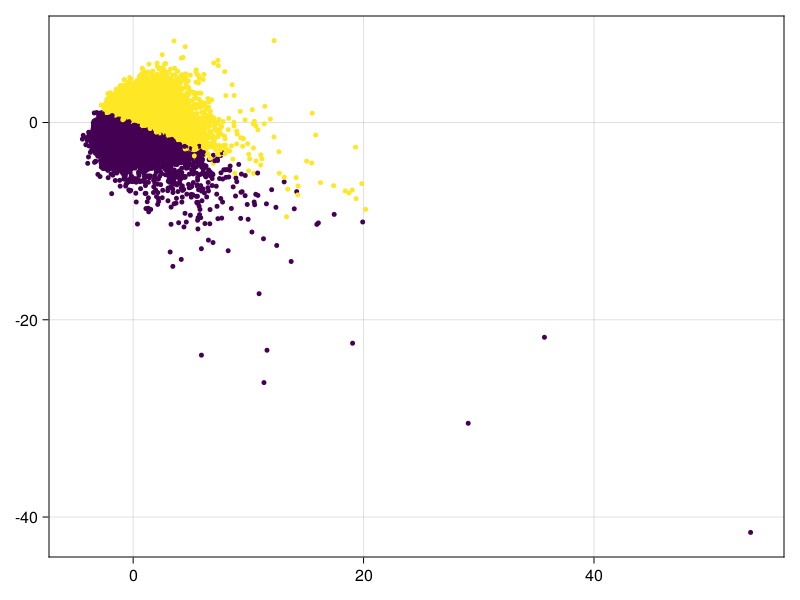

In [32]:
label = kmeans_label(tree, 2)
plot_clusters(tree, label)

In [34]:
PCA_model = fit(PCA, tree, maxoutdim = 2);
PCA_data = predict(PCA_model,tree)
outlier = []
outlier_PCA = []
for i in 1:size(PCA_data, 2)
    if PCA_data[:,i][1] >25
        append!(outlier, [sample_tree[i]])
        append!(outlier_PCA, [PCA_data[:,i]])
    end
end
display(outlier_PCA)
display(outlier)

3-element Vector{Any}:
 [29.082689972113275, -30.493455898700283]
 [53.593715378926916, -41.560199402540626]
 [35.70023512169391, -21.777488940369896]

3-element Vector{Any}:
 HybridNetwork, Rooted Network
10 edges
11 nodes: 6 tips, 0 hybrid nodes, 5 internal tree nodes.
tip labels: 2, 3, 5, 1, ...
((2:0.004,(3:0.01,(5:0.002,(1:0.014,6:0.005):0.001):0.041):0.005):0.001,4:0.011);

 HybridNetwork, Rooted Network
9 edges
10 nodes: 6 tips, 0 hybrid nodes, 4 internal tree nodes.
tip labels: 2, 3, 1, 5, ...
(2:0.001,(3:0.036,((1:0.031,5:0.012):0.001,6:0.021):0.007):0.01,4:0.226);

 HybridNetwork, Rooted Network
10 edges
11 nodes: 6 tips, 0 hybrid nodes, 5 internal tree nodes.
tip labels: 6, 1, 3, 4, ...
(6:0.001,(1:0.039,(((3:0.001,4:0.001):0.013,2:0.061):0.008,5:0.034):0.001):0.029);


In [13]:
cluster_1 = Vector{HybridNetwork}()
cluster_2 = Vector{HybridNetwork}() 
for i in 1:length(sample_tree)
    if label[i] == 1
        push!(cluster_1,sample_tree[i])
    else
        push!(cluster_2,sample_tree[i])
    end
end

In [14]:
writeMultiTopology(cluster_1, "./dog-data/100k_cluster_1.trees")
writeMultiTopology(cluster_2, "./dog-data/100k_cluster_2.trees")

In [35]:
Random.seed!(2023)
sample_tree = sample(trees, 200000, replace=false)
tree = print_bipartition(sample_tree, 6)
tree = standardize_tree(tree);

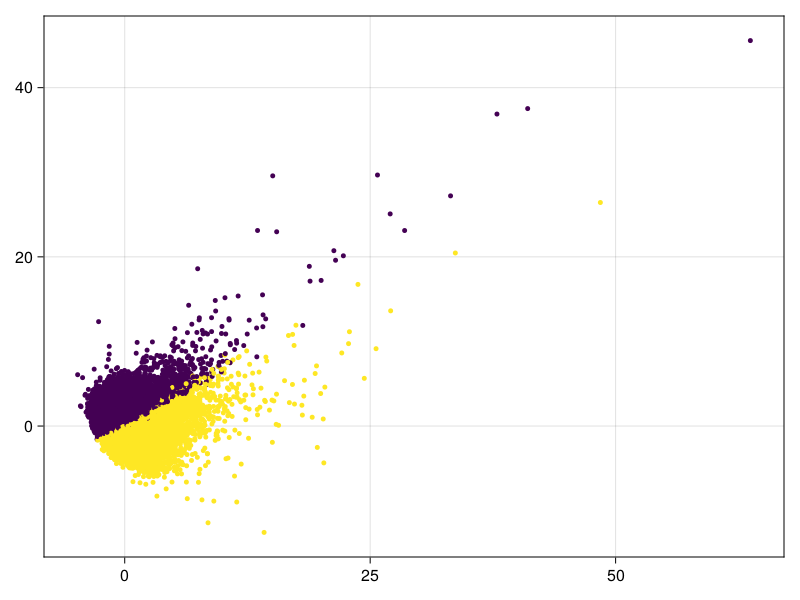

In [36]:
label = kmeans_label(tree, 2);
plot_clusters(tree, label)

In [38]:
PCA_model = fit(PCA, tree, maxoutdim = 2);
PCA_data = predict(PCA_model,tree)
outlier = []
outlier_PCA = []
for i in 1:size(PCA_data, 2)
    if PCA_data[:,i][1] >50
        append!(outlier, [sample_tree[i]])
        append!(outlier_PCA, [PCA_data[:,i]])
    end
end
display(outlier_PCA)
display(outlier)

1-element Vector{Any}:
 [63.72507748972512, 45.564439323231646]

1-element Vector{Any}:
 HybridNetwork, Rooted Network
9 edges
10 nodes: 6 tips, 0 hybrid nodes, 4 internal tree nodes.
tip labels: 2, 3, 1, 5, ...
(2:0.001,(3:0.036,((1:0.031,5:0.012):0.001,6:0.021):0.007):0.01,4:0.226);


In [39]:
cluster_1 = Vector{HybridNetwork}()
cluster_2 = Vector{HybridNetwork}() 
for i in 1:length(sample_tree)
    if label[i] == 1
        push!(cluster_1,sample_tree[i])
    else
        push!(cluster_2,sample_tree[i])
    end
end

In [40]:
writeMultiTopology(cluster_1, "./dog-data/200k_cluster_1.trees")
writeMultiTopology(cluster_2, "./dog-data/200k_cluster_2.trees")

In [11]:
# Testthe condition of rooting trees first
Random.seed!(376)
sample_tree = sample(trees, 100000, replace=false);
writeMultiTopology(sample_tree, "./dog-data/sample_100k.trees")

In [13]:
Random.seed!(2023)
sample_tree = sample(trees, 200000, replace=false);
writeMultiTopology(sample_tree, "./dog-data/sample_200k.trees")

In [45]:
sample_tree = readMultiTopology("dog-data/sample_100k_rooted.trees");
tree = print_bipartition(sample_tree, 6)
tree = standardize_tree(tree);

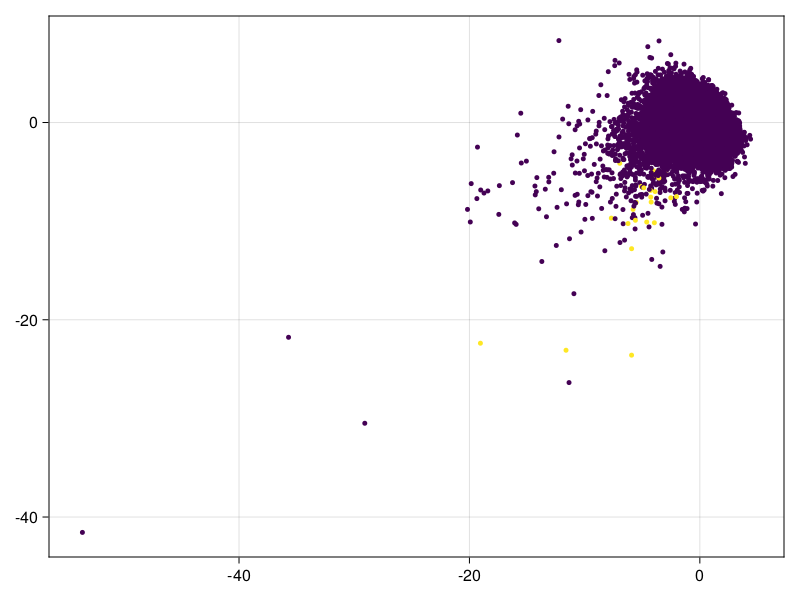

In [49]:
label = kmeans_label(tree, 2);
plot_clusters(tree, label)

In [50]:
cluster_1 = Vector{HybridNetwork}()
cluster_2 = Vector{HybridNetwork}() 
for i in 1:length(sample_tree)
    if label[i] == 1
        push!(cluster_1,sample_tree[i])
    else
        push!(cluster_2,sample_tree[i])
    end
end
writeMultiTopology(cluster_1, "./dog-data/100k_rooted_cluster_1.trees")
writeMultiTopology(cluster_2, "./dog-data/100k_rooted_cluster_2.trees")